#### Load data sets

In [1]:
import pandas as pd

import import_ipynb
from utilities import *
from preprocessing import preprocessing
from vectorization import *
from knn import *

# read data sets
data_set  = pd.read_csv("../data_sets/data_set.tsv", delimiter="\t",names=["id","title","content","category"],header=0)
train_set = pd.read_csv("../data_sets/train_set.tsv",delimiter="\t",names=["id","title","content","category"],header=0)
test_set  = pd.read_csv("../data_sets/test_set.tsv", delimiter="\t",names=["id","title","content"],           header=0)

# display dataframes
display(data_set.shape,data_set.head(3))
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

importing Jupyter notebook from utilities.ipynb
importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from vectorization.ipynb
importing Jupyter notebook from knn.ipynb


(2225, 4)

,id,title,content,category
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business


(1780, 4)

,id,title,content,category
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech


(445, 3)

,id,title,content
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...


#### Preprocessing

In [2]:
# associate category names with numerical index
data_set["category_id"] = data_set["category"].factorize()[0]

start_time = timer()

# concatenate title and content
data_set["title_and_content"] = data_set["title"] + " " + data_set["content"]

# some stop words for better results
more_stop_words = ["say","said","want","thing","may","see","make","look","likely","well","told","uses","used","use","bn","mr","year","people","new"]

# create an object of preprocessing class
preprocess = preprocessing()
# execute preprocessing for "title_and_content" column
data_set = preprocess.clean_stem_lemmatize_tokens_column(data_set, "title_and_content", more_stop_words, True)

# display dataframe
display(data_set.head(5))

timer(start_time)

train_set = pd.merge(train_set, data_set,on=["id","title","content","category"])
test_set = pd.merge(test_set, data_set,on=["id","title","content"])
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

,id,title,content,category,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,Ad sales boost Time Warner profit\n \n Quarte...,ad sale boost time warner profit quarterli pro...,"[ad, sale, boost, time, warner, profit, quarte..."
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,Dollar gains on Greenspan speech\n \n The dol...,dollar gain greenspan speech dollar hit highes...,"[dollar, gain, greenspan, speech, dollar, hit,..."
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,Yukos unit buyer faces loan claim\n \n The ow...,yuko unit buyer face loan claim owner embattl ...,"[yuko, unit, buyer, face, loan, claim, owner, ..."
3,4,High fuel prices hit BA's profits\n,\n British Airways has blamed high fuel price...,business,0,High fuel prices hit BA's profits\n \n Britis...,high fuel price hit ba profit british airway b...,"[high, fuel, price, hit, ba, profit, british, ..."
4,5,Pernod takeover talk lifts Domecq\n,\n Shares in UK drinks and food firm Allied D...,business,0,Pernod takeover talk lifts Domecq\n \n Shares...,pernod takeov talk lift domecq share uk drink ...,"[pernod, takeov, talk, lift, domecq, share, uk..."


'Time spent: 0:0:26'

(1780, 8)

,id,title,content,category,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment,1,Incredibles win animation awards\n \n The Inc...,incred win anim award incred movi beaten shrek...,"[incred, win, anim, award, incred, movi, beate..."
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport,3,Hantuchova in Dubai last eight\n \n Daniela H...,hantuchova dubai last eight daniela hantuchova...,"[hantuchova, dubai, last, eight, daniela, hant..."
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech,4,More power to the people says HP\n \n The dig...,power say hp digit revolut focus let tell shar...,"[power, say, hp, digit, revolut, focus, let, t..."


(445, 8)

,id,title,content,category,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,0,Tate & Lyle boss bags top award\n \n Tate & L...,tate lyle bos bag top award tate lyle chief ex...,"[tate, lyle, bos, bag, top, award, tate, lyle,..."
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,4,Halo 2 sells five million copies\n \n Microso...,halo sell five million copi microsoft celebr b...,"[halo, sell, five, million, copi, microsoft, c..."
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,2,MSPs hear renewed climate warning\n \n Climat...,msp hear renew climat warn climat chang could ...,"[msp, hear, renew, climat, warn, climat, chang..."


In [3]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

"""
roc_plot: plots roc curves for a classifier


"""
def roc_plot(model_name, model, train_X, train_Y, test_X, test_Y, vectorizer_name, directory):
    train_Y = label_binarize(train_Y, classes=[0, 1, 2, 3, 4])
    test_Y = label_binarize(test_Y, classes=[0, 1, 2, 3, 4])
    number_of_classes = train_Y.shape[1]

    if model_name == "knn":
        model = KNeighborsClassifier(n_neighbors=3)
    # calculate score
    classifier = OneVsRestClassifier(model)
    if model_name == "svm":
        score_Y = classifier.fit(train_X, train_Y).decision_function(test_X)
    else:
        score_Y = classifier.fit(train_X, train_Y).predict_proba(test_X)

    # calculate roc curve an roc area for each class
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    for i in range(number_of_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(test_Y[:, i], score_Y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # calculate micro average roc curve and roc area
    fpr["micro"],tpr["micro"],thresholds["micro"] = roc_curve(test_Y.ravel(), score_Y.ravel())
    roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
    
    # plot next to each other
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

    # plot roc curve
    axes[0].plot(fpr[2],tpr[2],color="indigo",lw=2,label="ROC curve (area = %0.2f)" % roc_auc[2])
    axes[0].plot([0,1],[0,1],color="navy",lw=2,linestyle="--")
    axes[0].set_xlim([0.0,1.0])
    axes[0].set_ylim([0.0,1.05])
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"{model_name}_{vectorizer_name}: Roc curve")
    axes[0].legend(loc="lower right")
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(number_of_classes)]))

    # interpolate roc curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(number_of_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # calculate average and auc
    mean_tpr /= number_of_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    ret_roc_auc = roc_auc["macro"]

    # plot multi-class roc curves
    colors = cycle(["aqua","darkorange","cornflowerblue","green","grey"])
    for i, color in zip(range(number_of_classes), colors):
        axes[1].plot(fpr[i],tpr[i],color=color,lw=2,label=f"ROC curve of class {i} (area = {roc_auc[i]})")

    axes[1].plot([0,1],[0,1],"k--",lw=2)
    axes[1].set_xlim([0.0,1.0])
    axes[1].set_ylim([0.0,1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"{model_name}_{vectorizer_name}: Multi-class Roc curves")
    axes[1].legend(loc="lower right")

    # save plot as png
    create_directory(directory)
    plt.savefig(f"{directory}/{model_name}_{vectorizer_name}_roc_curves.png")

## Classification

Classification is a process related to categorization, the process in which ideas and objects are recognized, differentiated and understood.

In [4]:
import warnings
from sklearn import svm, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# hide warnings
warnings.filterwarnings("ignore")

# calculate_best_parameters: calculates best parameters for
#                            a model by running GridSearchCV
"""
calculate_best_parameters: calculates best parameters for
                           a model by running GridSearchCV
                           
model:      estimator
parameters: dictionary
train_X:    training data
train_Y:    training labels
"""
def calculate_best_parameters(model,parameters,train_X,train_Y):
    clf = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = -1)
    clf.fit(train_X,train_Y)
    return clf.best_params_

"""
run_model: runs a specific classification model

model_name:      estimator name
report:          pandas dataframe
best_params:     dictionary
train_X:         training data
train_Y:         training labels
test_X:          testing data
test_Y:          testing labels
vectorizer_name: string
directory:       string
"""
def run_model(model_name, report, best_params, train_X, train_Y, test_X, test_Y, vectorizer_name, directory):
    if model_name == "svm":
        model = svm.SVC(C=best_params["C"],kernel=best_params["kernel"],gamma=best_params["gamma"])
    elif model_name == "rf":
        model = RandomForestClassifier(bootstrap=best_params["bootstrap"], max_depth=best_params["max_depth"],
                                   max_features=best_params["max_features"],n_estimators=best_params["n_estimators"],
                                   min_samples_split=best_params["min_samples_split"],
                                   min_samples_leaf=best_params["min_samples_leaf"],random_state=0)
    elif model_name == "nb":
        model = naive_bayes.MultinomialNB()
    elif model_name == "knn":
        model = knn()
        
    model.fit(train_X,train_Y)
    prediction = model.predict(test_X)
    
    # calculate statistics
    report.loc[model_name,"precision"] += precision_score(prediction, test_Y,average='macro')
    report.loc[model_name,"recall"] += recall_score(prediction, test_Y,average='macro')
    report.loc[model_name,"f-measure"] += f1_score(prediction, test_Y,average='macro')
    report.loc[model_name,"accurasy"] += accuracy_score(prediction, test_Y)

    # plot roc curves
    if directory is not None:
        roc_plot(model_name,model,train_X,train_Y,test_X,test_Y,vectorizer_name,directory)

"""
execute_models: executes all the models

train_X:         training data
train_Y:         training labels
test_X:          testing data
test_Y:          testing labels
vectorizer_name: string
report:          pandas dataframe
directory:       string
"""
def execute_models(train_X, train_Y, test_X, test_Y, vectorizer_name, report,directory):
    # run GridSearchCV to find best parameters for svc
    parameters = {"kernel":("rbf","linear"),"C":[1,5,10],"gamma":("scale","auto")}
    best_params = calculate_best_parameters(svm.SVC(),parameters,train_X,train_Y)
    # run SVM model
    run_model("svm",report,best_params,train_X,train_Y,test_X,test_Y,vectorizer_name,directory)
    # found best parameters for RF from GridSearchCV
    best_params={
                "bootstrap": True,
                "max_depth": 100,
                "max_features": 3,
                "min_samples_leaf": 3,
                "min_samples_split": 10,
                "n_estimators": 1000
                }
    # run RF model
    run_model("rf",report,best_params,train_X,train_Y,test_X,test_Y,vectorizer_name,directory)
    # run NB model
    run_model("nb",report,None,train_X,train_Y,test_X,test_Y,vectorizer_name,directory)
    # run (my) KNN model
    run_model("knn",report,None,train_X,train_Y,test_X,test_Y,vectorizer_name,directory)

"""
classification: runs all the classification algorithms for bow or tf-idf vectorizer

train_set:       pandas dataframe
test_set:        pandas dataframe
column:          string
label_column:    string
report:          pandas dataframe
vectorizer_name: string
directory:       string
"""
def classification(train_set, test_set, column, label_column, report, vectorizer_name, directory = None):
    if vectorizer_name is "bow":
        train_X, test_X = bag_of_words_calculate(train_set, test_set, column)
    elif vectorizer_name is "tf_idf":
        train_X, test_X = tf_idf_calculate(train_set, test_set, column)
    train_Y = np.asarray(train_set[label_column].tolist())
    test_Y = np.asarray(test_set[label_column].tolist())
    
    # execute SVM, RF, NB and (my) KNN models
    execute_models(train_X, train_Y, test_X, test_Y, vectorizer_name, report, directory)

Some functions for creating a dataframe report.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

"""
initialize_report: creates and returns a dataframe report
"""
def initialize_report():
    report = {"svm":[0,0,0,0],"rf":[0,0,0,0],"nb":[0,0,0,0],"knn":[0,0,0,0]}
    report = pd.DataFrame.from_dict(report,orient="index",columns=["precision","recall","f-measure","accurasy"])
    return report

"""
display_report: displays our dataframe report

arguments:
    report:          pandas dataframe
    title:           string
    vectorizer_name: string
    directory:       None or string
"""
def display_report(report, title, vectorizer_name, directory = None):
    display(title)
    display("----------------------------------------")
    display(vectorizer_name)
    display(report)
    if directory is not None:
        fig = plt.figure(facecolor =  "w", edgecolor = "k")
        sns.heatmap(report, annot = True, cmap = "viridis", cbar = False)
        create_directory(directory)
        plt.savefig(f"{directory}/{vectorizer_name}_statistics.png")

Classification for train and test set

In [6]:
start_time = timer()

# bag of words
bow_report = initialize_report()
classification(train_set,test_set, "content", 
               "category_id", bow_report, "bow")
display_report(bow_report, "content", "bow")

# tf-idf
tf_idf_report = initialize_report()
classification(train_set,test_set, "content", 
               "category_id", tf_idf_report, "tf_idf")
display_report(tf_idf_report, "content", "tf_idf")

timer(start_time)

'content'

'----------------------------------------'

'bow'

,precision,recall,f-measure,accurasy
svm,0.906879,0.907992,0.907341,0.912360
rf,0.900986,0.907242,0.902958,0.905618
nb,0.926781,0.925057,0.925128,0.928090
knn,0.720520,0.731260,0.714503,0.723596


'content'

'----------------------------------------'

'tf_idf'

,precision,recall,f-measure,accurasy
svm,0.937134,0.935810,0.936421,0.939326
rf,0.906833,0.918678,0.911555,0.914607
nb,0.917740,0.923300,0.920133,0.923596
knn,0.875125,0.866429,0.868956,0.871910


'Time spent: 0:15:38'

### 10-Fold Cross Validation

Cross-validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set.

In [7]:
from sklearn.model_selection import KFold

"""
k_fold_cross_validation: run fold cross validation for k splits

arguments:
    splits:          int
    dataframe:       pandas dataframe
    columns:         string
    column:          string
    label_column:    string
    vectorizer_name: string
    directory:       None or string
"""
def k_fold_cross_validation(splits, dataframe, columns, column, label_column, vectorizer_name, directory = None):
    kf = KFold(n_splits=splits)
    report = initialize_report()
    for index, (train_index, test_index) in enumerate(kf.split(dataframe),start=1):
        # get train and test values
        train_set_f = dataframe.iloc[train_index.tolist(),:].values
        test_set_f = dataframe.iloc[test_index.tolist(),:].values
        # create train and test dataframes
        train_set_f = pd.DataFrame(train_set_f, columns=columns)
        test_set_f  = pd.DataFrame(test_set_f , columns=columns)
        # run classification and create report
        if ((index == splits) and (directory is not None)):
            classification(train_set_f, test_set_f, column, label_column, report, vectorizer_name, directory)
        else:
            classification(train_set_f, test_set_f, column, label_column, report, vectorizer_name)
            
    # devide all report columns with K splits
    report_columns = ["precision","recall","f-measure","accurasy"]
    report[report_columns] /= splits
    display_report(report, column, vectorizer_name, directory)

I shuffle my data set rows because they are grouped by category and then i run 10 fold cross validation.

In [8]:
classification_directory = "./classification_output"

columns = ["id","title","content","category","category_id","title_and_content",
           "title_and_content_clean_stems_lemmas","title_and_content_clean_stems_lemmas_tokens"]

# shuffle dataset because it is grouped by category
shuffled_data_set = data_set.sample(frac = 1).reset_index(drop = True)
display(shuffled_data_set.shape,shuffled_data_set.head(3))

(2225, 8)

,id,title,content,category,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,1998,Gadgets galore on show at fair\n,\n The 2005 Consumer Electronics Show in Las ...,tech,4,Gadgets galore on show at fair\n \n The 2005 ...,gadget galor show fair consum electron show la...,"[gadget, galor, show, fair, consum, electron, ..."
1,2075,Video phone help for deaf people\n,\n Deaf people who prefer to communicate usin...,tech,4,Video phone help for deaf people\n \n Deaf pe...,video phone help deaf deaf prefer commun use b...,"[video, phone, help, deaf, deaf, prefer, commu..."
2,69,Boeing unveils new 777 aircraft\n,\n US aircraft firm Boeing has unveiled its n...,business,0,Boeing unveils new 777 aircraft\n \n US aircr...,boe unveil aircraft u aircraft firm boe unveil...,"[boe, unveil, aircraft, u, aircraft, firm, boe..."


'content'

'----------------------------------------'

'bow'

,precision,recall,f-measure,accurasy
svm,0.908328,0.910579,0.908186,0.910587
rf,0.912559,0.922306,0.914893,0.917289
nb,0.921116,0.920400,0.919957,0.922260
knn,0.751962,0.763898,0.746934,0.752828


'content'

'----------------------------------------'

'tf_idf'

,precision,recall,f-measure,accurasy
svm,0.942683,0.942786,0.942065,0.943825
rf,0.924607,0.934364,0.927217,0.928532
nb,0.918577,0.924260,0.920144,0.922254
knn,0.876563,0.877825,0.874634,0.879116


'Time spent: 1:28:16'

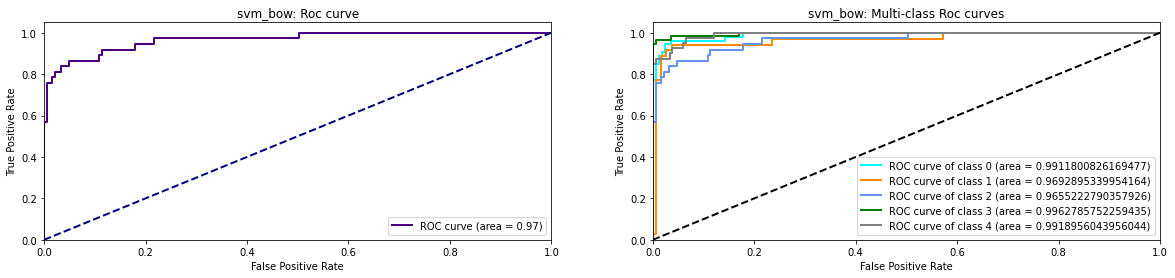

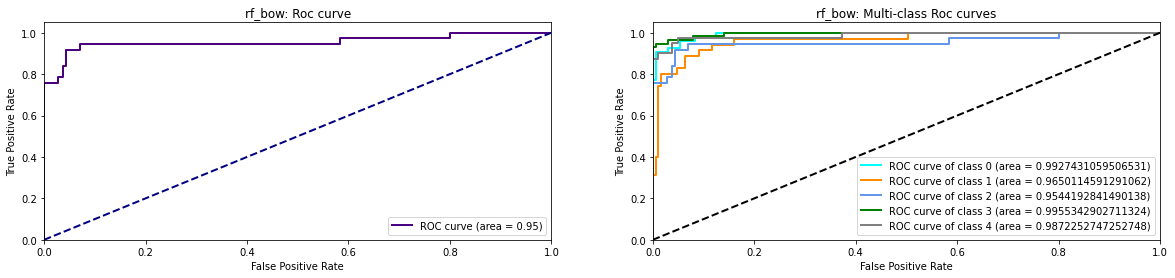

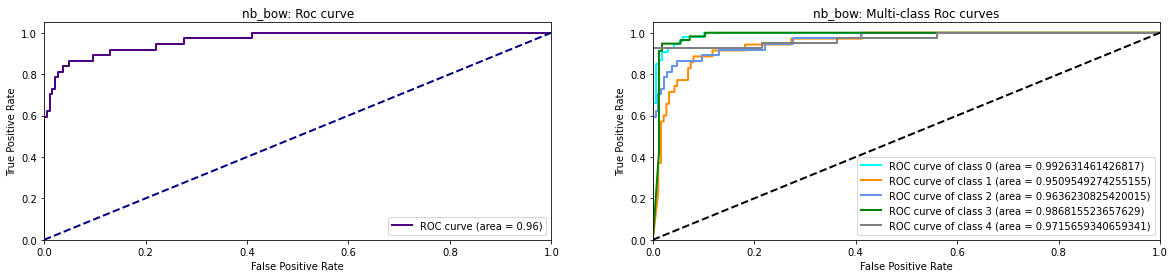

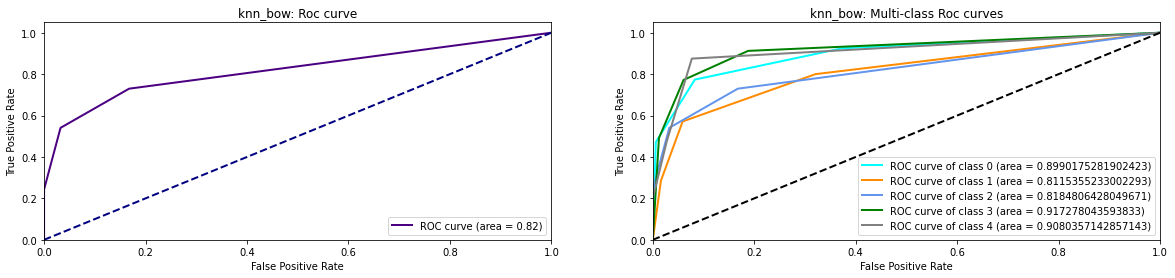

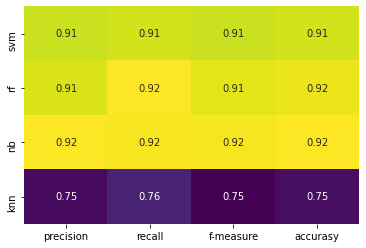

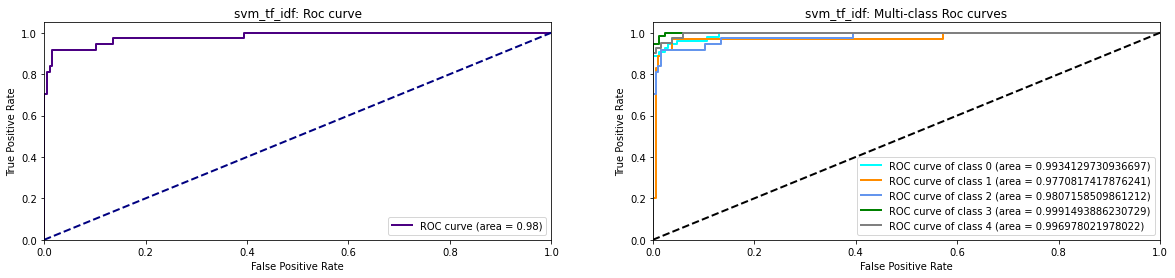

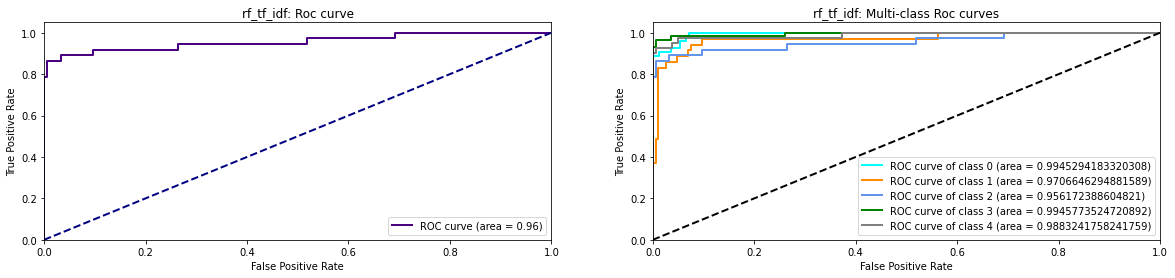

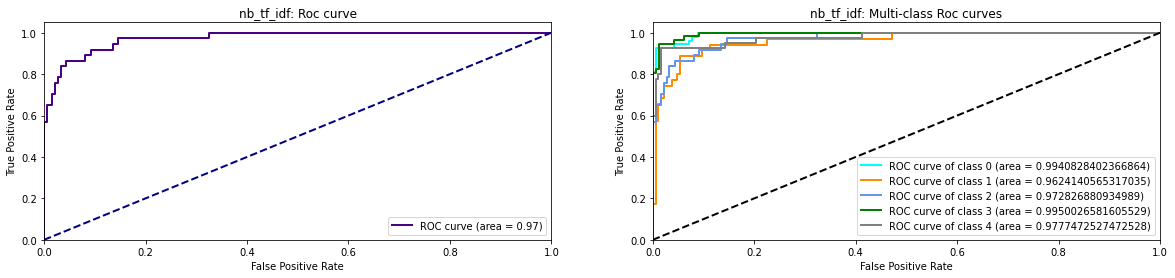

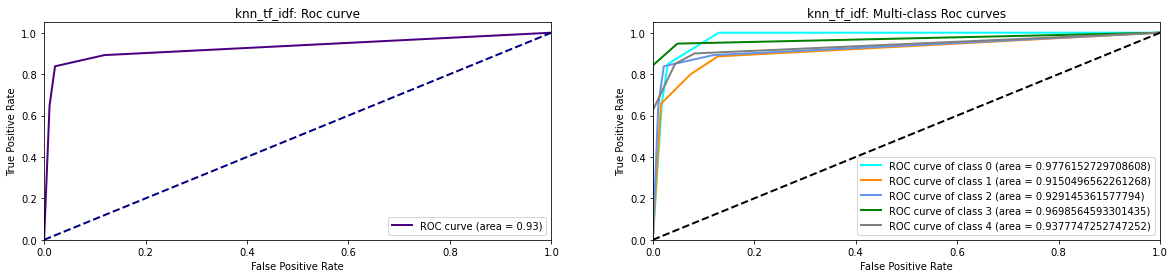

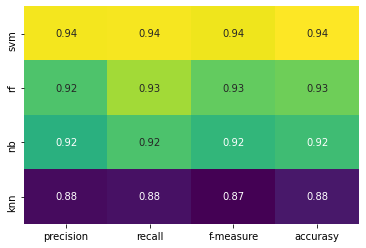

In [9]:
start_time = timer()

# bag of words
k_fold_cross_validation(10, shuffled_data_set, columns, "content",
                        "category_id", "bow", classification_directory)

# tf-idf
k_fold_cross_validation(10, shuffled_data_set, columns, "content",
                        "category_id", "tf_idf", classification_directory)

timer(start_time)

#### Beat the benchmark

Classification for cleaned, stemmed, lemmatized title concatenated with content.

In [10]:
start_time = timer()

# bag of words
bow_report = initialize_report()
classification(train_set,test_set, "title_and_content_clean_stems_lemmas",
               "category_id", bow_report, "bow")
display_report(bow_report, "title_and_content_clean_stems_lemmas", "bow")

# tf-idf
tf_idf_report = initialize_report()
classification(train_set,test_set, "title_and_content_clean_stems_lemmas",
               "category_id", tf_idf_report, "tf_idf")
display_report(tf_idf_report, "title_and_content_clean_stems_lemmas", "tf_idf")

timer(start_time)

'title_and_content_clean_stems_lemmas'

'----------------------------------------'

'bow'

,precision,recall,f-measure,accurasy
svm,0.936788,0.935723,0.936091,0.937079
rf,0.925571,0.938363,0.930944,0.932584
nb,0.923751,0.920108,0.921818,0.923596
knn,0.872364,0.867988,0.869224,0.874157


'title_and_content_clean_stems_lemmas'

'----------------------------------------'

'tf_idf'

,precision,recall,f-measure,accurasy
svm,0.940669,0.938040,0.939279,0.939326
rf,0.932059,0.940845,0.935808,0.937079
nb,0.923146,0.924326,0.923641,0.925843
knn,0.887156,0.881079,0.882998,0.887640


'Time spent: 0:15:7'

10-fold cross validation for cleaned, stemmed, lemmatized title concatenated with content

In [11]:
start_time = timer()

# bag of words
k_fold_cross_validation(10, shuffled_data_set, columns,
                        "title_and_content_clean_stems_lemmas", "category_id", "bow")

# tf-idf
k_fold_cross_validation(10, shuffled_data_set,columns,
                        "title_and_content_clean_stems_lemmas", "category_id", "tf_idf")

timer(start_time)

'title_and_content_clean_stems_lemmas'

'----------------------------------------'

'bow'

,precision,recall,f-measure,accurasy
svm,0.941224,0.941494,0.940428,0.942470
rf,0.946402,0.951266,0.947596,0.949196
nb,0.943837,0.942886,0.942571,0.943815
knn,0.903259,0.905230,0.902792,0.904723


'title_and_content_clean_stems_lemmas'

'----------------------------------------'

'tf_idf'

,precision,recall,f-measure,accurasy
svm,0.955527,0.955536,0.954962,0.956391
rf,0.945025,0.949335,0.946121,0.947398
nb,0.939350,0.941642,0.939642,0.941114
knn,0.904686,0.904499,0.903160,0.905605


'Time spent: 1:25:32'